In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
import xgboost as xgb

In [2]:
df_ramen=pd.read_csv("C:/Users/hiten/Downloads/ramen-ratings.csv")
df_ramen.rename(columns={'Top Ten':"Top10","Review #":"Review"},inplace=True)

In [3]:
df_ramen.Style.replace(np.nan,"Pack",inplace=True)

In [7]:
df_ramen.Brand=LabelEncoder().fit_transform(df_ramen.Brand)
df_ramen.Country=LabelEncoder().fit_transform(df_ramen.Country)
df_ramen.Style=LabelEncoder().fit_transform(df_ramen.Style)
df_ramen.drop(columns=['Top10','Review'],inplace=True)

In [8]:
df_ramen_copy2=df_ramen.copy()

In [9]:
stars_df=df_ramen_copy2[['Stars']]

In [10]:
stars_df.Stars.replace('Unrated',0,inplace=True)
stars_df['Stars']=stars_df.Stars.astype(float)

C:\Users\hiten\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-10-51d13354cc62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_df['Stars']=stars_df.Stars.astype(float)


In [11]:
stars_df.Stars=stars_df["Stars"].apply(lambda x:  round(x))

C:\Users\hiten\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
df_ramen_copy2.drop(columns=[  'Stars','Variety'],inplace=True)

In [13]:
x=df_ramen_copy2.iloc[:,:3]
y=stars_df.Stars
scaled=StandardScaler()
scaled_x=scaled.fit_transform(x)

In [14]:
data_matrix=xgb.DMatrix(data=x,label=y)
param_xgb={
    'learning_rates':[0.1,0.2,0.3],
    'max_depth':7,
    'alpha':10,
    'n_estimators':10
}

[21:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } might not be used.

  This may not be acc

<AxesSubplot:>

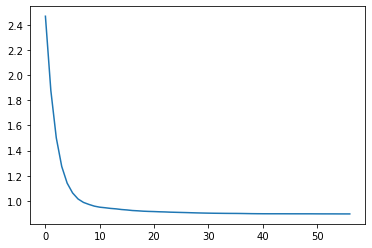

In [15]:
result=xgb.cv(
    dtrain=data_matrix,
    params=param_xgb,
    nfold=3,
    num_boost_round=100,
    early_stopping_rounds=10,
    metrics='rmse',
    as_pandas=True
)
result['train-rmse-mean'].plot()

In [16]:
grid_serach_param=[
    (max_depth,min_child_weight,learning_rates)
    for max_depth in range(5,25,3)
    for min_child_weight in range(1,12,3)
    for learning_rates in np.arange(.1,1,.05)
]

In [17]:
min_rmse=float('inf')
best_params=None
for max_depth, min_child_weight,lr in grid_serach_param:
    print(f'cv with max depth={max_depth}, min_child_weight={min_child_weight}')
    param_xgb['max_depth']=max_depth
    param_xgb['min_child_weight']=min_child_weight
    param_xgb['learning_rates']=lr
    result=xgb.cv(
        dtrain=data_matrix,
    params=param_xgb,
    nfold=3,
    num_boost_round=100,
    early_stopping_rounds=10,
    metrics='rmse',
    as_pandas=True
    )
    mean_rmse=result['test-rmse-mean'].min()
    boost_rounds=result['test-rmse-mean'].argmin()
    if mean_rmse<min_rmse:
        min_rmse=mean_rmse
        best_params=(max_depth,min_child_weight,lr)

cv with max depth=5, min_child_weight=1
[21:00:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:00:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:00:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } m

In [18]:
print(f"Best params: {best_params[0]}, {best_params[1]}, {best_params[2]} with minimum rmse: {min_rmse} ")

Best params: 14, 7, 0.1 with minimum rmse: 0.9672139999999999 


In [19]:
param_xgb['learning_rate'] = 0.1
param_xgb['max_depth'] = 14
param_xgb['alpha'] = 10
param_xgb['min_child_weight'] = 7
param_xgb

{'learning_rates': 0.9500000000000003,
 'max_depth': 14,
 'alpha': 10,
 'n_estimators': 10,
 'min_child_weight': 7,
 'learning_rate': 0.1}

In [20]:
tx,testx,ty,testy=train_test_split(x,y,random_state=0)
dtrain=xgb.DMatrix(data=tx,label=ty)
dtest=xgb.DMatrix(data=testx,label=testy)

In [21]:
model=xgb.train(
    param_xgb,
    dtrain,
    num_boost_round=200,
    evals=[(dtest,"Test")],
    early_stopping_rounds=10
)

[21:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-rmse:3.06933
[1]	Test-rmse:2.80220
[2]	Test-rmse:2.56548
[3]	Test-rmse:2.35458
[4]	Test-rmse:2.17003
[5]	Test-rmse:2.00553
[6]	Test-rmse:1.86385
[7]	Test-rmse:1.73828
[8]	Test-rmse:1.63004
[9]	Test-rmse:1.53561
[10]	Test-rmse:1.45646
[11]	Test-rmse:1.38742
[12]	Test-rmse:1.32838
[13]	Test-rmse:1.27833
[14]	Test-rmse:1.23678
[15]	Test-rmse:1.20253
[16]	Test-rmse:1.17316
[17]	Test-rmse:1.14848
[18]	Test-rmse:1.12817
[19]	Test-rmse:1.10997
[20]	Test-rmse:1.09522
[21]	Test-rmse:1.08308
[22]	Test-rmse:1.07270
[23]	Test-rmse:1.06508
[24]	Test-rmse:1.05844
[25]	Test-rmse:1.05194
[26]	T

In [22]:
num_boost_round=model.best_iteration+1
best_model=xgb.train(
    param_xgb,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest,"Test")]
)

[21:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learning_rates, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-rmse:3.06933
[1]	Test-rmse:2.80220
[2]	Test-rmse:2.56548
[3]	Test-rmse:2.35458
[4]	Test-rmse:2.17003
[5]	Test-rmse:2.00553
[6]	Test-rmse:1.86385
[7]	Test-rmse:1.73828
[8]	Test-rmse:1.63004
[9]	Test-rmse:1.53561
[10]	Test-rmse:1.45646
[11]	Test-rmse:1.38742
[12]	Test-rmse:1.32838
[13]	Test-rmse:1.27833
[14]	Test-rmse:1.23678
[15]	Test-rmse:1.20253
[16]	Test-rmse:1.17316
[17]	Test-rmse:1.14848
[18]	Test-rmse:1.12817
[19]	Test-rmse:1.10997
[20]	Test-rmse:1.09522
[21]	Test-rmse:1.08308
[22]	Test-rmse:1.07270
[23]	Test-rmse:1.06508
[24]	Test-rmse:1.05844
[25]	Test-rmse:1.05194
[26]	T

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
pred=best_model.predict(dtest)
np.sqrt(mean_squared_error(testy,pred))

0.9928912911008387

In [25]:
best_model.save_model("Ramen.model")

In [26]:
loaded_model=xgb.Booster()
loaded_model.load_model("Ramen.model")

In [27]:
loaded_model.predict(dtest)

array([3.3094363, 4.168594 , 3.6880822, 4.185287 , 3.5740461, 3.7678566,
       3.4845371, 3.053855 , 3.8753793, 3.9750848, 3.8691318, 3.5639498,
       3.006945 , 4.023537 , 3.053855 , 4.166963 , 3.7678566, 3.962752 ,
       3.962752 , 3.4908957, 4.0812597, 2.909913 , 3.9376092, 3.4160013,
       3.8497376, 3.479259 , 3.5985181, 4.166629 , 3.2628326, 3.5680857,
       3.7889895, 3.077127 , 3.7216563, 3.5980942, 3.8126142, 3.1499653,
       4.141898 , 3.462482 , 3.2212286, 3.7581913, 3.5404682, 3.1964903,
       3.8808775, 3.7216563, 3.9384584, 3.5374901, 3.5844705, 4.268204 ,
       3.4692373, 3.722703 , 3.5680857, 4.0340867, 3.543522 , 3.9277189,
       3.8852835, 3.5533435, 3.9219675, 2.8978846, 4.0481052, 3.870005 ,
       4.1324058, 3.6454191, 3.9845345, 3.7401736, 3.9277189, 4.268204 ,
       4.185287 , 3.030757 , 4.336525 , 4.1500735, 4.141898 , 3.7064762,
       3.8030145, 3.629581 , 3.278245 , 3.9933918, 3.8012304, 4.129973 ,
       3.9845345, 3.7401736, 3.7889895, 3.4908957, 

C:\Users\hiten\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\hiten\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


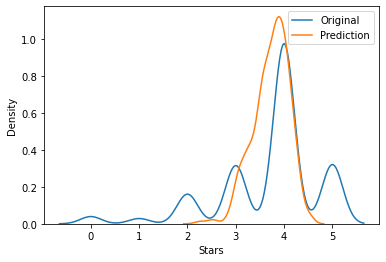

In [29]:
sns.distplot(y,hist=False,label='Original')
sns.distplot(pred,hist=False,label='Prediction')
plt.legend()
plt.show()

In [30]:
import pickle

In [35]:
with open('../../Mini_project/Code_ramen_rating/Ramen_n.pkl','wb') as f:
    pickle.dump(best_model, f)
    print('model saved')

model saved


In [36]:
with open('../../Mini_project/Code_ramen_rating/Ramen_n.pkl','rb') as f:
    model = pickle.load(f)
    print('model loaded')

model loaded


In [37]:
model

In [31]:
pickle.dump(model, open('Ramen.model', 'wb'))

In [32]:
def save_model(path, model):
    with open(path,'wb') as f:
        pickle.dump(model, f)
    return path

def load_model(path):
    with open(path,'rb') as f:
        return pickle.load(f)
    